In [10]:

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import generator


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


Dataset ImageFolder
    Number of datapoints: 1000
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


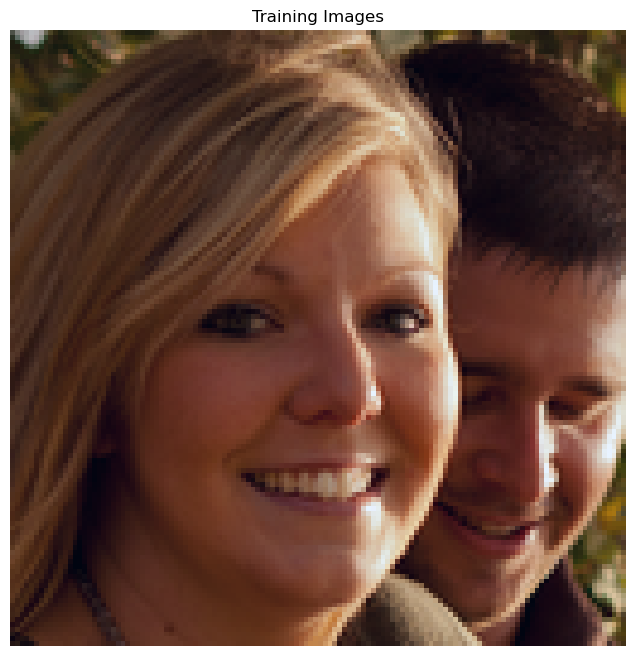

In [11]:
dataset = dset.ImageFolder(root="images",transform=transforms.Compose([transforms.Resize(128),transforms.CenterCrop(128),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True)

# Decide which device we want to run on

print(dataset)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))
plt.show()

In [152]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, feature_map_size,image_channels=3):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # input is ``(image_channels) x 64 x 64``
            nn.Conv2d(image_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(feature_map_size) x 32 x 32``
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(feature_map_size*2) x 16 x 16``
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(feature_map_size*4) x 8 x 8``
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_map_size * 8, feature_map_size * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(feature_map_size*8) x 4 x 4``
            nn.Conv2d(feature_map_size * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

import torch.nn as nn
class Generator(nn.Module):
    def __init__(self,input_size ,size_feature_map, image_channels = 3):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( input_size, size_feature_map * 16, 4, 2, 0, bias=False),
            nn.BatchNorm2d(size_feature_map * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( size_feature_map * 16, size_feature_map * 8, 4,2, 0, bias=False),
            nn.BatchNorm2d(size_feature_map * 8),
            nn.ReLU(True),
            # state size. ``(size_feature_map*8) x 4 x 4``
            nn.ConvTranspose2d(size_feature_map * 8, size_feature_map * 4, 2, 2, 1, bias=False),
            nn.BatchNorm2d(size_feature_map * 4),
            nn.ReLU(True),
            # state size. ``(size_feature_map*4) x 8 x 8``
            nn.ConvTranspose2d( size_feature_map * 4, size_feature_map * 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(size_feature_map * 2),
            nn.ReLU(True),
            # state size. ``(size_feature_map*2) x 16 x 16``
            nn.ConvTranspose2d( size_feature_map * 2, size_feature_map, 1, 2, 1, bias=False),
            nn.BatchNorm2d(size_feature_map),
            nn.ReLU(True),
            # state size. ``(size_feature_map) x 32 x 32``
            nn.ConvTranspose2d( size_feature_map, image_channels, 2, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [153]:
netgen = Generator(128,128)
netdisc = Discriminator(128)
print(netgen)
print(netdisc)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, e

In [154]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, 128, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netgen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netdisc.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [155]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netdisc.zero_grad()
        # Format batch
        real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float)
        print(len(real_cpu))
        # Forward pass real batch through D
        output = netdisc(real_cpu).view(-1)
        print(len(output))        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1)
        # Generate fake image batch with G
        fake = netgen(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netdisc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netgen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netdisc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netgen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
1
1
[0/100][0/1000]	Loss_D: 1.3004	Loss_G: 0.6107	D(x): 0.5960	D(G(z)): 0.5430 / 0.5430
1
1


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 3, 2, 2]] is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()